# Aligning HST Mosaics 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

# Introduction

This notebook demonstrates how to align and drizzle mosaicked tiles of the Eagle Nebula (M16) obtained with WFC3 with both UVIS and IR detectors. It is based on the example highlighted in the following WFC3 technical report: [ISR 2015-09: Combining WFC3 Mosaics of M16 with DrizzlePac](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf)
and highlights special features in DrizzlePac to improve mosaics. 

In prior alignment [tutorials](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt), building up an aligned set of tiles required an iterative approach. Now, mosaic alignment can be achieved in a single step by building up an expanded reference catalog ‘on-the-fly’. New sky matching options make it easier to produce seamless mosaics, which can be challenging for extended sources with little or no blank sky. 

In [1]:
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii
from astropy.visualization import ZScaleInterval
from IPython.display import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Observations

Mosaics of the Eagle Nebula were acquired by HST GO/DD [program 13926](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13926&observatory=HST) in September 2014 for HST's 25th Annivery. A 2x2 tile mosaic with the IR detector (~4 arcmin across) was observed in the F110W and F160W filters. 

A slightly larger 2x2 mosaic with the UVIS detector (~5 arcmin across) was observed with the F502N, F657N, and F673N filters. Small dithers between exposures in a given tile will fill in the UVIS chip gap and allow for the rejection of cosmic rays and detector artifacts. More detail on the observing strategy may be found in the [Phase II file](http://www.stsci.edu/hst/phase2-public/13926.pro).

Two additional UVIS tiles overlap the central portion of 2x2 mosaic in order to have very high signal-to-noise in the Eagle's pillars. These two visits (09,10) were not included in this example for brevity. The data used in this notebook example is also limited to the IR/F160W filter (visits 01-04) and UVIS/F657N filters (visits 05-08), shown in the diagrams below.
>      IR Mosaic           UVIS Mosaic         UVIS(overlap)
>      ____ ____            ____ ____            ____ 
>     |    |    |          |    |    |          |    |   
>     | 02 | 01 |          | 06 | 05 |          | 09 | 
>     |____|____|          |____|____|          |____|
>     |    |    |          |    |    |          |    |  
>     | 04 | 03 |          | 08 | 07 |          | 10 |
>     |____|____|          |____|____|          |____|

# 2. MAST Download

In the steps below, the calibrated IR data (\*\_flt.fits) and the calibrated, CTE-corrected UVIS data (\*\_flc.fits) are retrieved from MAST and placed in the same directory as this notebook, along with the associated telemetry and engineering files (\*\_spt.fits).

In [2]:
# Retrieve the IR/F160W calibrated FLT and SPT data products  
science_list = Observations.query_criteria(proposal_id='13926', filters='F160W')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLT', 'SPT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

INFO: Found cached file ./science/mastDownload/HST/hst_13926_04_wfc3_ir_f160w_ick904ob/hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits with expected size 16646400. [astroquery.query]
INFO: Found cached file ./science/mastDownload/HST/hst_13926_04_wfc3_ir_f160w_ick904og/hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits with expected size 16646400. [astroquery.query]
INFO: Found cached file ./science/mastDownload/HST/ick904030/ick904030_spt.fits with expected size 2424960. [astroquery.query]
INFO: Found cached file ./science/mastDownload/HST/ick904obq/ick904obq_spt.fits with expected size 1226880. [astroquery.query]
INFO: Found cached file ./science/mastDownload/HST/ick904obq/ick904obq_flt.fits with expected size 16634880. [astroquery.query]
INFO: Found cached file ./science/mastDownload/HST/ick904ogq/ick904ogq_spt.fits with expected size 1226880. [astroquery.query]
INFO: Found cached file ./science/mastDownload/HST/ick904ogq/ick904ogq_flt.fits with expected size 16634880. [astroquery.query]
INF

In [3]:
# Obtain the UVIS/F657N calibrated FLC and SPT data products from visits 05-08 
science_list = Observations.query_criteria(proposal_id='13926', filters='F657N', obs_id='ICK90[5678]*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLC', 'SPT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

# 3. Dithers

## 3a. IR detector
IR exposures were obtained in Visits 01-04. (The visit ID is found in the 5th and 6th character of the filename). Each visit (mosaic tile) consists of a pair of exposures using the WFC3-IR-DITHER-BLOB dither of 7.2" along the y-axis (pattern_orient=90 degrees). This dither can be seen when comparing the POSTARG2 keyword between pairs of exposures in a given visit in the table below. 

Pairs of IR exposures making up each visit are referred to as v01a and v01b in this notebook. The first four images listed in the table below are associated with v01a and the last four with v01b. 

In [4]:
collect_ir = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                 keywords=["asn_id", "detector", "filter", "nsamp",
                                           "exptime", "postarg1", "postarg2"])

ir_table = collect_ir.summary
ir_table['exptime'].format = '7.1f'
ir_table['postarg1'].format = '7.2f'
ir_table['postarg2'].format = '7.2f'
ir_table

file,asn_id,detector,filter,nsamp,exptime,postarg1,postarg2
str44,str9,str2,str5,int64,float64,float64,float64
hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits,ICK901030,IR,F160W,16,702.9,-62.57,-62.05
hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits,ICK901030,IR,F160W,16,702.9,-62.57,-54.85
hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits,ICK902030,IR,F160W,16,702.9,62.57,-62.05
hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits,ICK902030,IR,F160W,16,702.9,62.57,-54.85
hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits,ICK903030,IR,F160W,16,702.9,-62.57,54.85
hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits,ICK903030,IR,F160W,16,702.9,-62.57,62.05
hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits,ICK904030,IR,F160W,16,702.9,62.57,54.85
hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits,ICK904030,IR,F160W,16,702.9,62.57,62.05
ick901hzq_flt.fits,ICK901030,IR,F160W,16,702.9,-62.57,-62.05


## 3b. UVIS detector

UVIS exposures were acquired in Visits 05-08. Each UVIS visit (tile) consists of a set of 3 dithered exposures using the WFC3-UVIS-MOSAIC-LINE pattern, with an offset ~12" along a 65 degree diagonal. This dither can be seen in the POSTARG1, POSTARG2 offsets which are ~5" in X and ~10" in Y between exposures in a given visit. 

Sets of three exposures making up each UVIS visit are referred to as v05a, v05b, v05c in this notebook.

In [5]:
collect_uvis = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
                                   keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
uvis_table = collect_uvis.summary
uvis_table['exptime'].format = '7.1f'
uvis_table['postarg1'].format = '7.2f'
uvis_table['postarg2'].format = '7.2f'
uvis_table

file,asn_id,detector,filter,exptime,postarg1,postarg2
str46,str9,str4,str5,float64,float64,float64
hst_13926_05_wfc3_uvis_f657n_ick905k5_flc.fits,ICK905040,UVIS,F657N,600.0,-65.38,-74.27
hst_13926_05_wfc3_uvis_f657n_ick905ke_flc.fits,ICK905040,UVIS,F657N,600.0,-60.31,-63.40
hst_13926_05_wfc3_uvis_f657n_ick905kn_flc.fits,ICK905040,UVIS,F657N,600.0,-55.24,-52.52
hst_13926_06_wfc3_uvis_f657n_ick906kw_flc.fits,ICK906040,UVIS,F657N,600.0,65.38,-65.13
hst_13926_06_wfc3_uvis_f657n_ick906l5_flc.fits,ICK906040,UVIS,F657N,600.0,70.46,-54.25
hst_13926_06_wfc3_uvis_f657n_ick906le_flc.fits,ICK906040,UVIS,F657N,600.0,75.53,-43.38
hst_13926_07_wfc3_uvis_f657n_ick907nk_flc.fits,ICK907040,UVIS,F657N,600.0,-65.38,65.13
hst_13926_07_wfc3_uvis_f657n_ick907o1_flc.fits,ICK907040,UVIS,F657N,600.0,-60.31,76.00
hst_13926_07_wfc3_uvis_f657n_ick907ou_flc.fits,ICK907040,UVIS,F657N,600.0,-55.24,86.88


# 4. TweakReg for Mosaics

Before combining observations with AstroDrizzle, the WCS keywords in the header of each input frame
should be aligned to sub-pixel accuracy. This may be achieved with TweakReg, which allows users to align sets of images to one another or to an external astrometric reference frame. TweakReg has been enhanced to support the alignment of observations that cover a large area on the sky. Making use of the `expand_refcat` parameter, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. When set to 'True', TweakReg selects two images from the input list with the largest overlap on the sky, generates source catalogs for each image, and computes a fit (shift, rotation, and/or scale change) from the matched source list. 

Next, the algorithm computes the area of overlap of each of these two images with the rest of the input images, and the one with the largest total overlap on the sky is selected as the reference image. Sources from the second image that have not been matched to the reference image catalog are considered good new sources and are added to the reference catalog. In this way, the reference catalog keeps expanding with each new matched image. With a large (expanded) reference catalog it is therefore possible to align images that had no direct overlap with the starting image.

## 4a. IR Alignment

For this large multi-filter dataset, the user should carefully consider which observations to align and combine first. These will serve as a reference image for aligning additional filters. The broadband IR images of M16 contain a large number of stars distributed uniformly over the field of view. The UVIS frames, on the other hand, are largely devoid of point sources and full of cosmic-rays which can trip up TweakReg when trying to compute a fit. Even though the IR detector has a smaller footprint on the sky and the IR PSF is more undersampled, the high density of stars makes it a better anchor for aligning the UVIS tiles.

Of the two IR filters, F160W has the largest number of point sources and therefore makes a good choice for the reference image. To generate source lists for matching, the TweakReg parameter `conv_width` should be set to approximately twice the FWHM of the PSF, ~2.5 pixels for IR observations and ~3.5 pixels for UVIS observations. TweakReg will automatically compute the standard deviation of the sky background (`skysigma`), so the number of sources in each catalog may be controlled simply by changing the ‘threshold’ parameter. 

In this example, TweakReg is run in ‘non-interactive’ mode (`interactive='False'`) so that the astrometric fit residuals and vectors diagrams will be saved as png files in the user’s local directory for inspection. Once the parameters have been fine-tuned and the fit looks adequate, users may run TweakReg a second time (see below) to update the image header WCS keywords by setting the parameter `updatehdr` to True.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.0 started at: 10:45:17.226 (20/10/2022) 


TweakReg Version 3.5.0 started at: 10:45:17.226 (20/10/2022) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 10.0.0 ]


Python Version [Clang 10.0.0 ]


INFO:drizzlepac.util:3.8.10 (default, May 19 2021, 11:01:55) 


3.8.10 (default, May 19 2021, 11:01:55) 


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.1 


astropy Version -> 5.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits


    hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits


    hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits


    hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits


    hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits


    hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits


    hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits


    hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits


INFO:drizzlepac.tweakreg:    hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits


    hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits


INFO:drizzlepac.tweakreg:    ick901hzq_flt.fits


    ick901hzq_flt.fits


INFO:drizzlepac.tweakreg:    ick901i7q_flt.fits


    ick901i7q_flt.fits


INFO:drizzlepac.tweakreg:    ick902n9q_flt.fits


    ick902n9q_flt.fits


INFO:drizzlepac.tweakreg:    ick902neq_flt.fits


    ick902neq_flt.fits


INFO:drizzlepac.tweakreg:    ick903n4q_flt.fits


    ick903n4q_flt.fits


INFO:drizzlepac.tweakreg:    ick903ncq_flt.fits


    ick903ncq_flt.fits


INFO:drizzlepac.tweakreg:    ick904obq_flt.fits


    ick904obq_flt.fits


INFO:drizzlepac.tweakreg:    ick904ogq_flt.fits


    ick904ogq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	2.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	th

===  Source finding for image 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits', EXT=('SCI', 1) started at: 10:45:18.234 (20/10/2022)


  #  Source finding for 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits', EXT=('SCI', 1) started at: 10:45:18.234 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.029214
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:18.340 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 545 objects.


     Found 545 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits': 545


===  FINAL number of objects in image 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits': 545


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits':


===  Source finding for image 'hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits', EXT=('SCI', 1) started at: 10:45:18.478 (20/10/2022)


  #  Source finding for 'hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits', EXT=('SCI', 1) started at: 10:45:18.478 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.042417
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:18.621 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 524 objects.


     Found 524 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits': 524


===  FINAL number of objects in image 'hst_13926_01_wfc3_ir_f160w_ick901i7_flt.fits': 524


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits':


===  Source finding for image 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits', EXT=('SCI', 1) started at: 10:45:18.783 (20/10/2022)


  #  Source finding for 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits', EXT=('SCI', 1) started at: 10:45:18.783 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.440079
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:18.875 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 577 objects.


     Found 577 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits': 577


===  FINAL number of objects in image 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits': 577


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits':


===  Source finding for image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits', EXT=('SCI', 1) started at: 10:45:19.07 (20/10/2022)


  #  Source finding for 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits', EXT=('SCI', 1) started at: 10:45:19.07 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.440899
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:19.175 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 602 objects.


     Found 602 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits': 602


===  FINAL number of objects in image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits': 602


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits':


===  Source finding for image 'hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits', EXT=('SCI', 1) started at: 10:45:19.322 (20/10/2022)


  #  Source finding for 'hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits', EXT=('SCI', 1) started at: 10:45:19.322 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.478898
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:19.404 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 481 objects.


     Found 481 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits': 481


===  FINAL number of objects in image 'hst_13926_03_wfc3_ir_f160w_ick903n4_flt.fits': 481


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits':


===  Source finding for image 'hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits', EXT=('SCI', 1) started at: 10:45:19.55 (20/10/2022)


  #  Source finding for 'hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits', EXT=('SCI', 1) started at: 10:45:19.55 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.462718
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:19.637 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 498 objects.


     Found 498 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits': 498


===  FINAL number of objects in image 'hst_13926_03_wfc3_ir_f160w_ick903nc_flt.fits': 498


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits':


===  Source finding for image 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits', EXT=('SCI', 1) started at: 10:45:19.771 (20/10/2022)


  #  Source finding for 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits', EXT=('SCI', 1) started at: 10:45:19.771 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.456442
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:19.871 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 477 objects.


     Found 477 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits': 477


===  FINAL number of objects in image 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits': 477


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits':


===  Source finding for image 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits', EXT=('SCI', 1) started at: 10:45:20.04 (20/10/2022)


  #  Source finding for 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits', EXT=('SCI', 1) started at: 10:45:20.04 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.423880
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:20.122 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 445 objects.


     Found 445 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits': 445


===  FINAL number of objects in image 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits': 445


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick901hzq_flt.fits':


===  Source finding for image 'ick901hzq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick901hzq_flt.fits', EXT=('SCI', 1) started at: 10:45:20.245 (20/10/2022)


  #  Source finding for 'ick901hzq_flt.fits', EXT=('SCI', 1) started at: 10:45:20.245 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.029214
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:20.327 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 545 objects.


     Found 545 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick901hzq_flt.fits': 545


===  FINAL number of objects in image 'ick901hzq_flt.fits': 545


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick901i7q_flt.fits':


===  Source finding for image 'ick901i7q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick901i7q_flt.fits', EXT=('SCI', 1) started at: 10:45:20.459 (20/10/2022)


  #  Source finding for 'ick901i7q_flt.fits', EXT=('SCI', 1) started at: 10:45:20.459 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.042417
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:20.542 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 524 objects.


     Found 524 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick901i7q_flt.fits': 524


===  FINAL number of objects in image 'ick901i7q_flt.fits': 524


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick902n9q_flt.fits':


===  Source finding for image 'ick902n9q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick902n9q_flt.fits', EXT=('SCI', 1) started at: 10:45:20.681 (20/10/2022)


  #  Source finding for 'ick902n9q_flt.fits', EXT=('SCI', 1) started at: 10:45:20.681 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.440079
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:20.771 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 577 objects.


     Found 577 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick902n9q_flt.fits': 577


===  FINAL number of objects in image 'ick902n9q_flt.fits': 577


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick902neq_flt.fits':


===  Source finding for image 'ick902neq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick902neq_flt.fits', EXT=('SCI', 1) started at: 10:45:20.894 (20/10/2022)


  #  Source finding for 'ick902neq_flt.fits', EXT=('SCI', 1) started at: 10:45:20.894 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.440899
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:20.979 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 602 objects.


     Found 602 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick902neq_flt.fits': 602


===  FINAL number of objects in image 'ick902neq_flt.fits': 602


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick903n4q_flt.fits':


===  Source finding for image 'ick903n4q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick903n4q_flt.fits', EXT=('SCI', 1) started at: 10:45:21.096 (20/10/2022)


  #  Source finding for 'ick903n4q_flt.fits', EXT=('SCI', 1) started at: 10:45:21.096 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.478898
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:21.174 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 481 objects.


     Found 481 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick903n4q_flt.fits': 481


===  FINAL number of objects in image 'ick903n4q_flt.fits': 481


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick903ncq_flt.fits':


===  Source finding for image 'ick903ncq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick903ncq_flt.fits', EXT=('SCI', 1) started at: 10:45:21.287 (20/10/2022)


  #  Source finding for 'ick903ncq_flt.fits', EXT=('SCI', 1) started at: 10:45:21.287 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.462718
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:21.364 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 498 objects.


     Found 498 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick903ncq_flt.fits': 498


===  FINAL number of objects in image 'ick903ncq_flt.fits': 498


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick904obq_flt.fits':


===  Source finding for image 'ick904obq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick904obq_flt.fits', EXT=('SCI', 1) started at: 10:45:21.549 (20/10/2022)


  #  Source finding for 'ick904obq_flt.fits', EXT=('SCI', 1) started at: 10:45:21.549 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.456442
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:21.628 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 477 objects.


     Found 477 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick904obq_flt.fits': 477


===  FINAL number of objects in image 'ick904obq_flt.fits': 477


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick904ogq_flt.fits':


===  Source finding for image 'ick904ogq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick904ogq_flt.fits', EXT=('SCI', 1) started at: 10:45:21.767 (20/10/2022)


  #  Source finding for 'ick904ogq_flt.fits', EXT=('SCI', 1) started at: 10:45:21.767 (20/10/2022)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.423880
INFO:drizzlepac.catalogs:###Source finding finished at: 10:45:21.853 (20/10/2022)
INFO:drizzlepac.catalogs:     Found 445 objects.


     Found 445 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick904ogq_flt.fits': 445


===  FINAL number of objects in image 'ick904ogq_flt.fits': 445


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


derived from 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	2.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.3
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	o

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick902neq_flt.fits


Performing fit for: ick902neq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick902neq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'ick902neq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4563, 0.4452 with significance of 535.9 and 628 matches


Found initial X and Y shifts of 0.4563, 0.4452 with significance of 535.9 and 628 matches


INFO:drizzlepac.imgclasses:Found 601 matches for ick902neq_flt.fits...


Found 601 matches for ick902neq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick902neq_flt.fits : 


Computed  rscale  fit for  ick902neq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2431  YSH: 0.2057    ROT: 359.998917    SCALE: 0.999528


XSH: -0.2431  YSH: 0.2057    ROT: 359.998917    SCALE: 0.999528


INFO:drizzlepac.imgclasses:FIT XRMS: 0.00067    FIT YRMS: 0.0006 


FIT XRMS: 0.00067    FIT YRMS: 0.0006 


INFO:drizzlepac.imgclasses:FIT RMSE: 0.0009     FIT MAE: 0.00084


FIT RMSE: 0.0009     FIT MAE: 0.00084


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.3e-08 (deg)   RMS_DEC: 3.9e-09 (deg)


RMS_RA: 3.3e-08 (deg)   RMS_DEC: 3.9e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  601  objects.


Final solution based on  601  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick902neq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ick902neq_flt_catalog_fit.match


wrote XY data to:  ick902neq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 601


Total # points: 601


INFO:drizzlepac.tweakutils:# of points after clipping: 601


# of points after clipping: 601


INFO:drizzlepac.tweakutils:Total # points: 601


Total # points: 601


INFO:drizzlepac.tweakutils:# of points after clipping: 601


# of points after clipping: 601


INFO:drizzlepac.imgclasses:Adding 1 new sources to the reference catalog for a total of 603 sources.


Adding 1 new sources to the reference catalog for a total of 603 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ick902neq_flt.fits' ...


....Updating header for 'ick902neq_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick902neq_flt.fits['SCI',1]


Processing ick902neq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick902neq_flt.fits[1]


Updating header for ick902neq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.076101075736376e-05 -1.9449199587636616e-05


CD_11  CD_12: -3.076101075736376e-05 -1.9449199587636616e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1673829127999243e-05 2.7411388774370328e-05


CD_21  CD_22: -2.1673829127999243e-05 2.7411388774370328e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.72317303779994 -13.813735864077275


CRVAL    : 274.72317303779994 -13.813735864077275


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13540302127009443


Plate Scale : 0.13540302127009443


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.35683983551735


ORIENTAT : -35.35683983551735


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits


Performing fit for: hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.5052, 0.4027 with significance of 450 and 525 matches


Found initial X and Y shifts of 0.5052, 0.4027 with significance of 450 and 525 matches


INFO:drizzlepac.imgclasses:Found 498 matches for hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits...


Found 498 matches for hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits : 


Computed  rscale  fit for  hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0021  YSH: 0.0095    ROT: 0.00033942293    SCALE: 0.999989


XSH: -0.0021  YSH: 0.0095    ROT: 0.00033942293    SCALE: 0.999989


INFO:drizzlepac.imgclasses:FIT XRMS: 0.062      FIT YRMS: 0.045  


FIT XRMS: 0.062      FIT YRMS: 0.045  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.077      FIT MAE: 0.067  


FIT RMSE: 0.077      FIT MAE: 0.067  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 4.3e-08 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 4.3e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  484  objects.


Final solution based on  484  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_13926_02_wfc3_ir_f160w_ick902n9_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  hst_13926_02_wfc3_ir_f160w_ick902n9_flt_catalog_fit.match


wrote XY data to:  hst_13926_02_wfc3_ir_f160w_ick902n9_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 484


Total # points: 484


INFO:drizzlepac.tweakutils:# of points after clipping: 484


# of points after clipping: 484


INFO:drizzlepac.tweakutils:Total # points: 484


Total # points: 484


INFO:drizzlepac.tweakutils:# of points after clipping: 484


# of points after clipping: 484


INFO:drizzlepac.imgclasses:Adding 79 new sources to the reference catalog for a total of 682 sources.


Adding 79 new sources to the reference catalog for a total of 682 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits' ...


....Updating header for 'hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits['SCI',1]


Processing hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits[1]


Updating header for hst_13926_02_wfc3_ir_f160w_ick902n9_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0761958745010546e-05 -1.944992029182213e-05


CD_11  CD_12: -3.0761958745010546e-05 -1.944992029182213e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1674408894151e-05 2.7412100411413926e-05


CD_21  CD_22: -2.1674408894151e-05 2.7412100411413926e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.72198443942904 -13.812105303381836


CRVAL    : 274.72198443942904 -13.812105303381836


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13546941921501443


Plate Scale : 0.13546941921501443


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.3571398199625


ORIENTAT : -35.3571398199625


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick902n9q_flt.fits


Performing fit for: ick902n9q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick902n9q_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'ick902n9q_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4451, 0.527 with significance of 507.2 and 609 matches


Found initial X and Y shifts of 0.4451, 0.527 with significance of 507.2 and 609 matches


INFO:drizzlepac.imgclasses:Found 551 matches for ick902n9q_flt.fits...


Found 551 matches for ick902n9q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick902n9q_flt.fits : 


Computed  rscale  fit for  ick902n9q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2582  YSH: 0.2175    ROT: 359.9989871    SCALE: 0.999531


XSH: -0.2582  YSH: 0.2175    ROT: 359.9989871    SCALE: 0.999531


INFO:drizzlepac.imgclasses:FIT XRMS: 0.057      FIT YRMS: 0.04   


FIT XRMS: 0.057      FIT YRMS: 0.04   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.07       FIT MAE: 0.059  


FIT RMSE: 0.07       FIT MAE: 0.059  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.6e-06 (deg)   RMS_DEC: 2e-08 (deg)


RMS_RA: 2.6e-06 (deg)   RMS_DEC: 2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  535  objects.


Final solution based on  535  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick902n9q_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ick902n9q_flt_catalog_fit.match


wrote XY data to:  ick902n9q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 535


Total # points: 535


INFO:drizzlepac.tweakutils:# of points after clipping: 535


# of points after clipping: 535


INFO:drizzlepac.tweakutils:Total # points: 535


Total # points: 535


INFO:drizzlepac.tweakutils:# of points after clipping: 535


# of points after clipping: 535


INFO:drizzlepac.imgclasses:Adding 26 new sources to the reference catalog for a total of 710 sources.


Adding 26 new sources to the reference catalog for a total of 710 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ick902n9q_flt.fits' ...


....Updating header for 'ick902n9q_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick902n9q_flt.fits['SCI',1]


Processing ick902n9q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick902n9q_flt.fits[1]


Updating header for ick902n9q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.076151946398945e-05 -1.944954513589586e-05


CD_11  CD_12: -3.076151946398945e-05 -1.944954513589586e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.167416616139623e-05 2.7411813480700674e-05


CD_21  CD_22: -2.167416616139623e-05 2.7411813480700674e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7219845196444 -13.812105343113926


CRVAL    : 274.7219845196444 -13.812105343113926


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13540553150163298


Plate Scale : 0.13540553150163298


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.35690129458154


ORIENTAT : -35.35690129458154


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits


Performing fit for: hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.4055, 0.4204 with significance of 66 and 67 matches


Found initial X and Y shifts of 0.4055, 0.4204 with significance of 66 and 67 matches


INFO:drizzlepac.imgclasses:Found 67 matches for hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits...


Found 67 matches for hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits : 


Computed  rscale  fit for  hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2651  YSH: 0.3127    ROT: 359.9963092    SCALE: 0.999348


XSH: -0.2651  YSH: 0.3127    ROT: 359.9963092    SCALE: 0.999348


INFO:drizzlepac.imgclasses:FIT XRMS: 0.049      FIT YRMS: 0.044  


FIT XRMS: 0.049      FIT YRMS: 0.044  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.066      FIT MAE: 0.058  


FIT RMSE: 0.066      FIT MAE: 0.058  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.4e-06 (deg)   RMS_DEC: 2.7e-07 (deg)


RMS_RA: 2.4e-06 (deg)   RMS_DEC: 2.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  63  objects.


Final solution based on  63  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_13926_04_wfc3_ir_f160w_ick904ob_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  hst_13926_04_wfc3_ir_f160w_ick904ob_flt_catalog_fit.match


wrote XY data to:  hst_13926_04_wfc3_ir_f160w_ick904ob_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 63


Total # points: 63


INFO:drizzlepac.tweakutils:# of points after clipping: 63


# of points after clipping: 63


INFO:drizzlepac.tweakutils:Total # points: 63


Total # points: 63


INFO:drizzlepac.tweakutils:# of points after clipping: 63


# of points after clipping: 63


INFO:drizzlepac.imgclasses:Adding 410 new sources to the reference catalog for a total of 1122 sources.


Adding 410 new sources to the reference catalog for a total of 1122 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits' ...


....Updating header for 'hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits['SCI',1]


Processing hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits[1]


Updating header for hst_13926_04_wfc3_ir_f160w_ick904ob_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0761775993965766e-05 -1.9454676853784382e-05


CD_11  CD_12: -3.0761775993965766e-05 -1.9454676853784382e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1679938335901184e-05 2.741204235328446e-05


CD_21  CD_22: -2.1679938335901184e-05 2.741204235328446e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.74080693631385 -13.838430234330625


CRVAL    : 274.74080693631385 -13.838430234330625


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13539355255414426


Plate Scale : 0.13539355255414426


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36380936716212


ORIENTAT : -35.36380936716212


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick904obq_flt.fits


Performing fit for: ick904obq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick904obq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'ick904obq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.5933, 0.306 with significance of 261.5 and 481 matches


Found initial X and Y shifts of -0.5933, 0.306 with significance of 261.5 and 481 matches


INFO:drizzlepac.imgclasses:Found 477 matches for ick904obq_flt.fits...


Found 477 matches for ick904obq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick904obq_flt.fits : 


Computed  rscale  fit for  ick904obq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3770  YSH: 0.2163    ROT: 359.9986164    SCALE: 1.000734


XSH: -0.3770  YSH: 0.2163    ROT: 359.9986164    SCALE: 1.000734


INFO:drizzlepac.imgclasses:FIT XRMS: 0.015      FIT YRMS: 0.0048 


FIT XRMS: 0.015      FIT YRMS: 0.0048 


INFO:drizzlepac.imgclasses:FIT RMSE: 0.016      FIT MAE: 0.005  


FIT RMSE: 0.016      FIT MAE: 0.005  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.6e-07 (deg)   RMS_DEC: 1.7e-07 (deg)


RMS_RA: 5.6e-07 (deg)   RMS_DEC: 1.7e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  419  objects.


Final solution based on  419  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick904obq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ick904obq_flt_catalog_fit.match


wrote XY data to:  ick904obq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 419


Total # points: 419


INFO:drizzlepac.tweakutils:# of points after clipping: 419


# of points after clipping: 419


INFO:drizzlepac.tweakutils:Total # points: 419


Total # points: 419


INFO:drizzlepac.tweakutils:# of points after clipping: 419


# of points after clipping: 419


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ick904obq_flt.fits' ...


....Updating header for 'ick904obq_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick904obq_flt.fits['SCI',1]


Processing ick904obq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick904obq_flt.fits[1]


Updating header for ick904obq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0721744420506554e-05 -1.9429240828700318e-05


CD_11  CD_12: -3.0721744420506554e-05 -1.9429240828700318e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.16513390752786e-05 2.7376219988822725e-05


CD_21  CD_22: -2.16513390752786e-05 2.7376219988822725e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.74077615445685 -13.8384269040406


CRVAL    : 274.74077615445685 -13.8384269040406


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13540409882643004


Plate Scale : 0.13540409882643004


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36379205941952


ORIENTAT : -35.36379205941952


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits


Performing fit for: hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.5945, 0.4055 with significance of 149.5 and 405 matches


Found initial X and Y shifts of -0.5945, 0.4055 with significance of 149.5 and 405 matches


INFO:drizzlepac.imgclasses:Found 398 matches for hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits...


Found 398 matches for hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits : 


Computed  rscale  fit for  hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2684  YSH: 0.2884    ROT: 359.994464    SCALE: 1.000607


XSH: -0.2684  YSH: 0.2884    ROT: 359.994464    SCALE: 1.000607


INFO:drizzlepac.imgclasses:FIT XRMS: 0.06       FIT YRMS: 0.043  


FIT XRMS: 0.06       FIT YRMS: 0.043  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.074      FIT MAE: 0.065  


FIT RMSE: 0.074      FIT MAE: 0.065  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.7e-06 (deg)   RMS_DEC: 4.2e-08 (deg)


RMS_RA: 2.7e-06 (deg)   RMS_DEC: 4.2e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  366  objects.


Final solution based on  366  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: hst_13926_04_wfc3_ir_f160w_ick904og_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  hst_13926_04_wfc3_ir_f160w_ick904og_flt_catalog_fit.match


wrote XY data to:  hst_13926_04_wfc3_ir_f160w_ick904og_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 366


Total # points: 366


INFO:drizzlepac.tweakutils:# of points after clipping: 366


# of points after clipping: 366


INFO:drizzlepac.tweakutils:Total # points: 366


Total # points: 366


INFO:drizzlepac.tweakutils:# of points after clipping: 366


# of points after clipping: 366


INFO:drizzlepac.imgclasses:Adding 47 new sources to the reference catalog for a total of 1169 sources.


Adding 47 new sources to the reference catalog for a total of 1169 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits' ...


....Updating header for 'hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits['SCI',1]


Processing hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits[1]


Updating header for hst_13926_04_wfc3_ir_f160w_ick904og_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0720855144183354e-05 -1.9429022735999295e-05


CD_11  CD_12: -3.0720855144183354e-05 -1.9429022735999295e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.165156322267398e-05 2.7375702441865404e-05


CD_21  CD_22: -2.165156322267398e-05 2.7375702441865404e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7419630524441 -13.840055731879621


CRVAL    : 274.7419630524441 -13.840055731879621


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13538467049590805


Plate Scale : 0.13538467049590805


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.363999749169906


ORIENTAT : -35.363999749169906


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick904ogq_flt.fits


Performing fit for: ick904ogq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick904ogq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'ick904ogq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.5945, 0.4055 with significance of 226.3 and 452 matches


Found initial X and Y shifts of -0.5945, 0.4055 with significance of 226.3 and 452 matches


INFO:drizzlepac.imgclasses:Found 445 matches for ick904ogq_flt.fits...


Found 445 matches for ick904ogq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick904ogq_flt.fits : 


Computed  rscale  fit for  ick904ogq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3935  YSH: 0.2084    ROT: 359.9984897    SCALE: 1.000701


XSH: -0.3935  YSH: 0.2084    ROT: 359.9984897    SCALE: 1.000701


INFO:drizzlepac.imgclasses:FIT XRMS: 0.068      FIT YRMS: 0.047  


FIT XRMS: 0.068      FIT YRMS: 0.047  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.083      FIT MAE: 0.07   


FIT RMSE: 0.083      FIT MAE: 0.07   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3e-06 (deg)   RMS_DEC: 3e-08 (deg)


RMS_RA: 3e-06 (deg)   RMS_DEC: 3e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  378  objects.


Final solution based on  378  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick904ogq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ick904ogq_flt_catalog_fit.match


wrote XY data to:  ick904ogq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 378


Total # points: 378


INFO:drizzlepac.tweakutils:# of points after clipping: 378


# of points after clipping: 378


INFO:drizzlepac.tweakutils:Total # points: 378


Total # points: 378


INFO:drizzlepac.tweakutils:# of points after clipping: 378


# of points after clipping: 378


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ick904ogq_flt.fits' ...


....Updating header for 'ick904ogq_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick904ogq_flt.fits['SCI',1]


Processing ick904ogq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick904ogq_flt.fits[1]


Updating header for ick904ogq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.072068337701219e-05 -1.9428900907476547e-05


CD_11  CD_12: -3.072068337701219e-05 -1.9428900907476547e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.165095473811348e-05 2.7375269126931208e-05


CD_21  CD_22: -2.165095473811348e-05 2.7375269126931208e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7419631200025 -13.840055681860497


CRVAL    : 274.7419631200025 -13.840055681860497


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13539574058669115


Plate Scale : 0.13539574058669115


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36425822519598


ORIENTAT : -35.36425822519598


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick901hzq_flt.fits


Performing fit for: ick901hzq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick901hzq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'ick901hzq_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.3537, 0.5779 with significance of 41.72 and 58 matches


Found initial X and Y shifts of 0.3537, 0.5779 with significance of 41.72 and 58 matches


INFO:drizzlepac.imgclasses:Found 51 matches for ick901hzq_flt.fits...


Found 51 matches for ick901hzq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick901hzq_flt.fits : 


Computed  rscale  fit for  ick901hzq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.3428  YSH: 0.1201    ROT: 0.004016348402    SCALE: 1.000051


XSH: -0.3428  YSH: 0.1201    ROT: 0.004016348402    SCALE: 1.000051


INFO:drizzlepac.imgclasses:FIT XRMS: 0.057      FIT YRMS: 0.27   


FIT XRMS: 0.057      FIT YRMS: 0.27   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.28       FIT MAE: 0.23   


FIT RMSE: 0.28       FIT MAE: 0.23   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 7.4e-06 (deg)   RMS_DEC: 6.7e-06 (deg)


RMS_RA: 7.4e-06 (deg)   RMS_DEC: 6.7e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  51  objects.


Final solution based on  51  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick901hzq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ick901hzq_flt_catalog_fit.match


wrote XY data to:  ick901hzq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 51


Total # points: 51


INFO:drizzlepac.tweakutils:# of points after clipping: 51


# of points after clipping: 51


INFO:drizzlepac.tweakutils:Total # points: 51


Total # points: 51


INFO:drizzlepac.tweakutils:# of points after clipping: 51


# of points after clipping: 51


INFO:drizzlepac.imgclasses:Adding 494 new sources to the reference catalog for a total of 1663 sources.


Adding 494 new sources to the reference catalog for a total of 1663 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ick901hzq_flt.fits' ...


....Updating header for 'ick901hzq_flt.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick901hzq_flt.fits['SCI',1]


Processing ick901hzq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick901hzq_flt.fits[1]


Updating header for ick901hzq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.07489734862874e-05 -1.9435683695155733e-05


CD_11  CD_12: -3.07489734862874e-05 -1.9435683695155733e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.165824143362266e-05 2.7400388624142875e-05


CD_21  CD_22: -2.165824143362266e-05 2.7400388624142875e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.69277874232796 -13.832220633739112


CRVAL    : 274.69277874232796 -13.832220633739112


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13540606532341462


Plate Scale : 0.13540606532341462


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.348895939555426


ORIENTAT : -35.348895939555426


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits


Performing fit for: hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


Matching sources from 'hst_13926_01_wfc3_ir_f160w_ick901hz_flt.fits' with sources from reference image 'hst_13926_02_wfc3_ir_f160w_ick902ne_flt.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.3933, 0.412 with significance of 483.5 and 571 matches


Found initial X and Y shifts of 0.3933, 0.412 with significance of 483.5 and 571 matches


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


ERROR:stsci.tools.logutil.exc:An unhandled exception ocurred:
Traceback (most recent call last):
  File "/Users/dulude/anaconda2/envs/py_3_8_10/lib/python3.8/site-packages/drizzlepac/util.py", line 230, in wrapper
    result = func(*args, **kwargs)
  File "/Users/dulude/anaconda2/envs/py_3_8_10/lib/python3.8/site-packages/drizzlepac/tweakreg.py", line 551, in run
    image.match(refimage, quiet_identity=False, **objmatch_par)
  File "/Users/dulude/anaconda2/envs/py_3_8_10/lib/python3.8/site-packages/drizzlepac/imgclasses.py", line 579, in match
    matches = xyxymatch(self.outxy, ref_outxy, origin=xyoff,
  File "/Users/dulude/anaconda2/envs/py_3_8_10/lib/python3.8/site-packages/stsci/stimage/__init__.py", line 236, in xyxymatch
    return _stimage.xyxymatch(
RuntimeError: Number of output coordinates exceeded allocation (545)


RuntimeError: Number of output coordinates exceeded allocation (545)

RuntimeError: Number of output coordinates exceeded allocation (545)

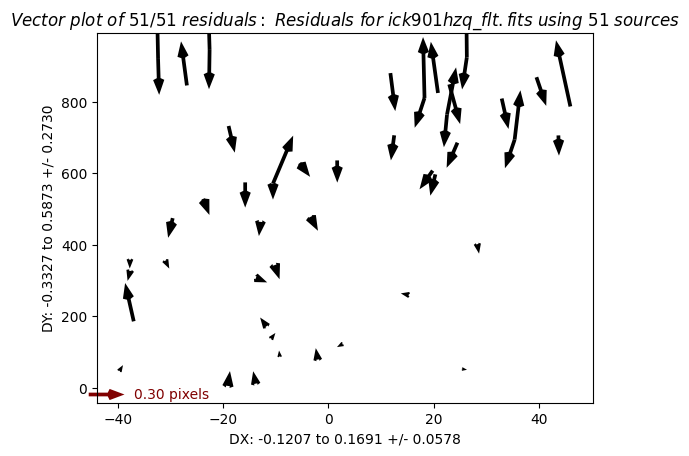

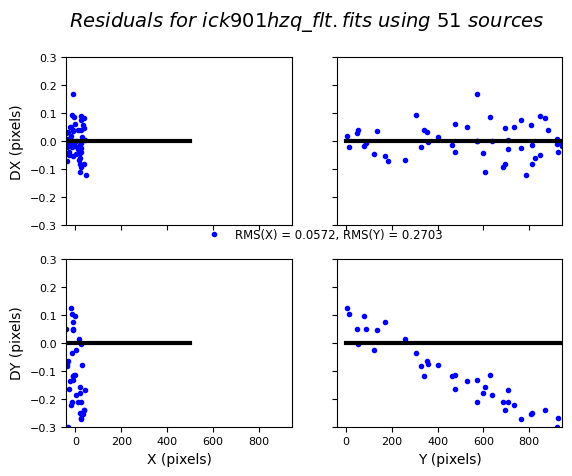

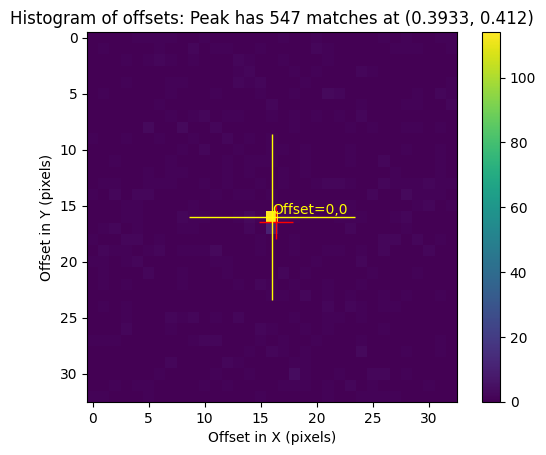

In [6]:
tweakreg.TweakReg('*flt.fits',
                  imagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  expand_refcat=True,
                  enforce_user_order=False,
                  shiftfile=True,
                  outshifts='shift160_flt.txt',
                  searchrad=2.0,
                  ylimit=0.3,
                  updatehdr=True,
                  reusename=True,
                  wcsname='IR_FLT',
                  interactive=False)

## 4b. Inspect the shift file to verify the pointing residuals 

With the `threshold` parameter set to 50 sigma, TweakReg finds ~500 objects per FLC image, matches the individual catalogs, and computes residual shifts between exposures. These offsets (given in pixels at the native IR scale=0.1283”/pixel) are recorded in an output “shift file” which is shown below.  Note that the fourth row of the shift file corresponds to the reference image ‘ick902neq_flt.fits’ which was automatically selected by TweakReg. The computed offsets reflect updates to the header WCS required to correct for small pointing errors.

In [ ]:
shift_table = Table.read('shift160_flt.txt',
                         format='ascii.no_header', 
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Appendix B](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/AppendixB2.html). Exposures making up visit-level drizzled products are typically aligned to 2-5 milliarcsecond (mas) accuracy with fine-lock on 2 guide stars. The shift file above confirms this, with offsets (dx,dy) between pairs of exposures in the same visit visit averaging ~0.05 IR pixels (6 mas). For different visits using the same set of guide stars, offsets of ~50-100 mas (0.6-1.2 IR pixels are expected. For visits with different sets of guide stars, the pointing accuracy is typically 0.2-0.5 arcseconds. 

The cell below shows how to check the image header for the 'Dominant' and 'Secondary' guide stars used. Since the M16 tiles (visits) each used different guide star pairs, the relatively large offsets (>1 arcsec) required for visits 03 and 04 to match the visit 02 reference image are not surprising, though are larger than expected. Note that the TweakReg `searchrad` parameter was increased to 2.0" from the default value of 1.0" to allow TweakReg to find the correct fit for these visits.

In [ ]:
collect_spt = ImageFileCollection('./', glob_include="ick9*0_spt.fits", ext=0,
                                  keywords=["asn_id", "config", "dgestar", "sgestar"])
table_spt = collect_spt.summary
table_spt

With `enforce_user_order='True'`, the FLC files were aligned in the order shown below. The exposure v02b was automatically selected as the reference and then v02a was selected as the image with the most overlap on the sky. The two input catalogs had 601 and 574 sources, respectively, and this gave 483 matches for the two exposures, after sigma-clipping. The reference catalog was then expanded by adding 73 new objects from the dithered exposure v02a to the matched catalog for a total of 674 sources. 

TweakReg next moved over to tile 04 and to align exposure v04a to the expanded catalog. In the overlap region between tiles, 63 matches were found along the upper edge of v04a. The reference catalog was expanded once again, adding the 411 sources from v04a to give a total of 1087 sources. Now when v04b is aligned, the number of matches is 388, since the expanded catalog now includes v04a. TweakReg continues in this way until all input frames are aligned to the expanded catalog, and the number of matches for each exposure is listed in the ascii table below. 

## 4c. Inspect the IR fits

To verify that TweakReg obtained a good fit between matched source catalogs, it is useful to inspect the results before updating the image header WCS. Below sources matched with the reference frame (v02b) are overplotted on the first input image (v02a). It can be useful to check that TweakReg locked onto stars and not hot pixels or other detector artifacts before proceeding. Next, the vector residuals plot is displayed and checked for any systematics. Finally, the 4-panel plot of fit residuals: dx, dy vs X and Y is inspected to verify that the residuals cluster around zero.   

In [ ]:
# v02a matches
plt.figure(figsize = (20, 7))
data = fits.open('ick902n9q_flt.fits')['SCI', 1].data
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick902n9q_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v02a to v02b(Ref)', fontsize=20)

In [ ]:
# v02a vector residuals
Image(filename='vector_ick902n9q_flt.png', width=500, height=300)

In [ ]:
# v02a fit residuals
Image(filename='residuals_ick902n9q_flt.png', width=500, height=300)

In [ ]:
# v04a matches (Edge overlap region only)
plt.figure(figsize = (20, 7))
data = fits.open('ick904obq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick904obq_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v04a to v02b(Ref)', fontsize=20)

In [ ]:
# v04a vector residuals (Edge gives narrow range of Y-values)
Image(filename='vector_ick904obq_flt.png', width=500, height=300)

In [ ]:
# v04a fit residuals (Edge gives narrow range of Y-values)
Image(filename='residuals_ick904obq_flt.png', width=500, height=300)

In [ ]:
# v04b matches (Full image since v04a already aligned)
plt.figure(figsize = (20, 7))
data = fits.open('ick904ogq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick904ogq_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v04b to v02b(Ref)', fontsize=20)

In [ ]:
# v04b vector residuals
Image(filename='vector_ick904ogq_flt.png', width=500, height=300)

In [ ]:
# v04b fit residuals
Image(filename='residuals_ick904ogq_flt.png', width=500, height=300)

In [ ]:
# v01a matches (Edge overlap region only)
plt.figure(figsize = (20, 7))
data = fits.open('ick901hzq_flt.fits')['SCI',1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin = 'lower', vmin = z1, vmax = z2)
match_tab = ascii.read('ick901hzq_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s = 30, edgecolor = 'r', facecolor = 'None')
plt.ylim(0,1014)
plt.xlim(0,1014)
plt.title('Match: v01a to v02b(Ref)', fontsize=20)

In [ ]:
# v01a vector residuals (Left edge gives narrow range of X-values)
Image(filename='vector_ick901hzq_flt.png', width=500, height=300)

In [ ]:
# v01a fit residuals (Left edge gives narrow range of X-values)
Image(filename='residuals_ick901hzq_flt.png', width=500, height=300)

In [ ]:
# v01b matches (Full image since v01a already aligned)

plt.figure(figsize = (20,7))
data = fits.open('ick901i7q_flt.fits')['SCI',1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin = 'lower', vmin = z1, vmax = z2)
match_tab = ascii.read('ick901i7q_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s = 30, edgecolor = 'r', facecolor = 'None')
plt.ylim(0,1014)
plt.xlim(0,1014)
plt.title('Match: v01b to v02b(Ref)', fontsize=20)

In [ ]:
# v01b vector residuals
Image(filename='vector_ick901i7q_flt.png', width=500, height=300)

In [ ]:
# v01b fit residuals
Image(filename='residuals_ick901i7q_flt.png', width=500, height=300)

In [ ]:
# v03a matches (Top and left edge overlap regions only)
plt.figure(figsize = (20, 7))
data = fits.open('ick903n4q_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick903n4q_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v03a to v02b(Ref)', fontsize=20)

In [ ]:
# v03a vector residuals (Top and left edges)
Image(filename='vector_ick903n4q_flt.png', width=500, height=300)

In [ ]:
# v03a fit residuals
Image(filename='residuals_ick903n4q_flt.png', width=500, height=300)

In [ ]:
# v03b matches (Full image since v03a already aligned)
plt.figure(figsize = (20, 7))
data = fits.open('ick903ncq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick903ncq_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v03b to v02b(Ref)', fontsize=20)

In [ ]:
# v03b vector residuals
Image(filename='vector_ick903ncq_flt.png', width=500, height=300)

In [ ]:
# v03b fit residuals
Image(filename='residuals_ick903ncq_flt.png', width=500, height=300)

The dx,dy residuals for all IR exposures are all clustered around dx,dy=0 and have an RMS less than 0.1 pixels, indicating a good fit. If the alignment needs to be fine-tuned, changing the parameters `threshold`, `sigma`, and `searchrad` may help TweakReg to lock onto an accurate solution. 

# 5. Mosaicking Features in AstroDrizzle

AstroDrizzle now makes it easier for users to match the sky background when tiling together large mosaics. In prior versions of the software, the sky background was based on clipped statistics in each image separately. The sky background was measured for each chip and the lowest sky value (in electrons/arcsec^2) among all of the chips was adopted. For observations of sparse fields, this approach generally works well. However, when large extended objects fill the detector, there is no true 'blank sky' and the background value will be an overestimate. Additionally, when extended targets are observed as mosaics (e.g. with large dithers), the 'scene' can change significantly between exposures and bias the background estimate.

An error in determining the sky background may in turn impact the cosmic ray rejection, and if severe enough, the resulting photometry. Additionally, by not properly matching the sky background before combining frames, correlated noise will be added to the final drizzled products when differences in the background levels are significant. Until now, the recommended workaround has been for users to give AstroDrizzle an ASCII file (`skyfile`) containing user-defined background values. 

AstroDrizzle now features several new options for computing the sky. One of these, `skymethod='match'`, is useful for “equalizing” the sky background across large mosaics. This method computes differences in sky values using only pixels in common between images. The sky values will then be set relative to the value computed for the input frame with the lowest sky value for which the MDRIZSKY keyword will be set to 0. In this way, the sky background is not removed, but instead equalized before the data are combined. For more details on the sky matching functions used by AstroDrizzle, see the following [webpage](https://stsci-skypac.readthedocs.io/en/latest/skymatch.html).

## 5a. Drizzle the IR/F160W Mosaic

Now AstroDrizzle can be used to combine the full set of F160W frames. In this case the final orientation has been set to -35 degrees so that the pillars will be oriented vertically. Note that users must first set the parameter `final_wcs='True'` in order to turn on parameters in AstroDrizzle’s step 7a: `Custom WCS for Final Output`. For these observations, the IR scale (0.08”/pixel) is chosen to be exactly twice that for the UVIS mosaics (0.04”/pixel) by setting `final_scale=0.08`, and the drizzled images have been oversized slightly to match the sky area on the sky covered by the UVIS. The sky background may be equalized across mosaic tiles by setting the parameter `skymethod='match'`.
   
The parameter `final_bits` defines which DQ flags in the FLT image to treat as good. All other pixels with non-zero DQ values will be assumed to be bad and rejected from the final mosaic. For IR data, these two parameters are typically set to 64+512 in the pipeline, corresponding to warm pixels and IR blobs. This program included a blob dither, however, and so the 512 flag may be removed from the list of good DQ values such that these pixels will be replaced with non-flagged pixels from the accompanying dithered pair. 

For IR data, cosmic-rays have already rejected via the 'up-the-ramp' fitting by calwf3, so Steps 3, 4, 5, 6 in AstroDrizzle have been turned off when combining the FLT exposures.  See [this reference](https://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html) for more information about the various input parameters to AstroDrizzle.

In [ ]:
astrodrizzle.AstroDrizzle('*flt.fits',
                          output='f160w',
                          preserve=False,
                          clean=True,
                          build=False,
                          context=False,
                          skymethod='match', 
                          driz_separate=False,
                          median=False,
                          blot=False,
                          driz_cr=False,
                          final_bits='64',
                          final_wcs=True,
                          final_scale=0.08,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=4000,
                          final_outny=4500)

## 5b. Display the combined DRZ science and weight images 

In [ ]:
sci = fits.getdata('f160w_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=1, vmax=6, cmap='Greys_r', origin='lower')

In [ ]:
wht = fits.getdata('f160w_drz_wht.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(wht, vmin=0, vmax=1700, cmap='Greys_r', origin='lower')

# 6. Align the UVIS FLC frames to the IR mosaic

The F160W drizzled mosaic defines the reference frame for aligning the UVIS filters. In [ISR 2015-09](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf), the UVIS visit-level DRC frames were aligned directly to the IR reference image, and this approach was chosen because the long UVIS exposures contain numerous cosmic-rays and relatively few point sources. The Drizzlepac task TweakBack was then used to propagate the updated WCS from the drizzled image header back to the individual FLC input frames making up each association prior to drizzling.

In this notebook, the FLC frames may be aligned directly to the IR mosaic by making use of a new parameter in TweakReg which allows for specific flags in the DQ array of the FLC frames to be used or ignored. The `imagefindpars` parameter `dqbits` may be prepended with ‘~’ to the string value to indicate which DQ flags to consider as "bad" pixels. For example, when deriving source catalogs, Tweakreg will ignore any pixels flagged as cosmic-ray flags in the MAST visit-level drizzled data products when `dqbits` is set to ~4096. This dramatically cuts down the number of false detections due to cosmic rays in the input FLC science arrays. More details on `imagefindpars` options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/deployment/imagefindpars.html). 

In this example, the `threshold` value was manually adjusted to get ~50 matches per UVIS exposure. Note that setting the `threshold` to a very low value does not necessarily translate to a better solution, since all sources are weighted equally when computing fits to match catalogs. This is especially relevant for UVIS data where CTE tails can shift the centroid position slightly along the readout direction for faint sources and potentially bias the fit.

In [ ]:
tweakreg.TweakReg('*_flc.fits',
                  enforce_user_order=False,
                  imagefindcfg={'threshold': 200, 'conv_width': 3.5, 'dqbits': ~4096},
                  refimage='f160w_drz_sci.fits', 
                  refimagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  shiftfile=True,
                  outshifts='shift657_flc.txt',
                  searchrad=5.0,
                  ylimit=0.6,
                  updatehdr=True,
                  wcsname='UVIS_FLC',
                  reusename=True,
                  interactive=False)

## 6a. Inspect the shift file to verify the pointing residuals 

With a `threshold` of 200 sigma, TweakReg generates catalogs with several hundred objects per UVIS image and it matches 20-70 objects to the IR reference catalog. The computed offsets written to the shift file are reported at the scale of the reference image (0.08”/pixel for the drizzled IR mosaic). Thus a fit rms ~0.20 pixels (below) at the IR scale is equivalent to an rms ~0.10 pixels at the native UVIS scale (0.04"/pixel).

Because each visit was acquired using a unique pair of Guide Stars, the three FLC exposures making up each visit should have roughly similar residual corrections to the WCS, which can be seen in the table below. Note that residual offsets for visit 05 are much larger than those found for the other three visits at nearly 3".

In [ ]:
shift_table=Table.read('shift657_flc.txt', format='ascii.no_header',
                       names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

## 6b. Inspect the UVIS fits

In [ ]:
#v06a matched sources (chip 1)
plt.figure(figsize=(20, 10))
chip1_data = fits.open('ick906l5q_flc.fits')['SCI', 2].data
z1, z2 = zscale.get_limits(chip1_data)
plt.imshow(chip1_data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick906l5q_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip1 = match_tab[match_tab['col15'] == 2]  # filter table for sources on chip 1 (on ext 4)
x_cord, y_cord = match_tab_chip1['col11'], match_tab_chip1['col12']
plt.scatter(x_cord, y_cord, s=50, edgecolor='r', facecolor='None', label='Matched Sources, Chip 1')
plt.ylim(0, 2051)
plt.xlim(0, 4096)
plt.legend(loc='best', fontsize=20)

In [ ]:
#v06a matched sources (chip 2)
plt.figure(figsize=(20, 10))
chip1_data = fits.open('ick906l5q_flc.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(chip1_data)
plt.imshow(chip1_data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick906l5q_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip2 = match_tab[match_tab['col15'] == 1]  # filter table for sources on chip 2 (on ext 1)
x_cord, y_cord = match_tab_chip2['col11'], match_tab_chip2['col12']
plt.scatter(x_cord, y_cord, s=50, edgecolor='r', facecolor='None', label='Matched Sources, Chip 2')
plt.ylim(0, 2051)
plt.xlim(0, 4096)
plt.legend(loc='best', fontsize=20)

In [ ]:
# v06a vector residuals
Image(filename='vector_ick906l5q_flc.png', width=600, height=300)

In [ ]:
# v06a fit residuals
Image(filename='residuals_ick906l5q_flc.png', width=600, height=300)

# 7. Drizzling the F657N mosaic

The full set of 12 FLC frames have now been aligned and may be drizzled to a mosaic exactly half the scale (0.04"/pixel) of the original IR mosaic (0.08"/pixel). The same output WCS paramters: `final_rot`,`final_ra`, and `final_dec` values are used, but the `final_outnx` and `final_outny` are now twice the size of the IR mosaic at 8000x9000 pixels. 

To save time for this notebook, the visit-level cosmic ray flags are assumed to be adequate, Steps 3, 4, 5, 6 are turned off, and the parameter `resetbits` is set to '0' to avoid wiping out the 4096 flags in the FLC data quality arrays. Also, the sky background levels have been provided via the skyfile parameter, but users would typically set `skymethod='match'` to compute the sky background levels. 

To further improve cosmic-ray rejection in the chip gap, AstroDrizzle may alternatively be run with all steps turned on as shown in the text below and with `resetbits=4096` to update the DQ flags. 

```
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f657n_improved',
                          preserve=False,
                          clean=False,
                          build=False,
                          context=False,
                          resetbits=4096,
                          skymethod='match',
                          combine_type='minmed',
                          final_bits='64,16',
                          final_wcs=True,
                          final_scale=0.04,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=8000,
                          final_outny=9000)
```

In [ ]:
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f657n',
                          preserve=False,
                          clean=False,
                          build=False,
                          context=False,
                          resetbits=0,
                          skyfile='skyfile.txt',
                          driz_separate=False,
                          median=False,
                          blot=False,
                          driz_cr=False,
                          final_bits='64,16',
                          final_wcs=True,
                          final_scale=0.04,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=8000,
                          final_outny=9000)

## 7a. Display the combined DRC science and weight images 

In [ ]:
sci = fits.getdata('f657n_drc_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=0, vmax=1, cmap='Greys_r', origin='lower')

In [ ]:
sci = fits.getdata('f657n_drc_wht.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=0, vmax=10000, cmap='Greys_r', origin='lower')

# Summary

This notebook provides the methodology for creating UVIS and IR mosaics of M16, as well as recommendations for key parameters. As such, it is relevant for users combining multi-visit observations from any HST imaging program, whether mosaics or single pointings. In this example, the IR F160W mosaic was chosen to define the reference frame, since it contained the largest number of point sources, despite the pixels being undersampled. Typically, the detector with the best resolution and PSF sampling would be selected as the reference, but in this case the UVIS catalogs were too sparse.

When building up an expanded reference catalog on the sky, TweakReg was allowed to select the order in which tiles were aligned, since it made little impact on the results. For aligning mosaics with more tiles, however, users are recommended to experiment with changing the order in which images are aligned and seeing how this changes the astrometric residuals.  Generally, users are advised to start from the center of the mosaic and work their way out to avoid propogation of errors across the mosaic. 

Alternatively, mosaic tiles can be aligned directly to an absolute reference catalog such as GAIA, when a sufficient number of stars are available in the input frames for alignment. For more detail on this methodology, see the notebook 'aligning_to_catalogs.ipynb'. 

# About this Notebook

    Author: J. Mack, STScI WFC3 Team  
    Updated: December 17, 2018